In [27]:
df_frontpage["leaning"].unique()

array(['Lean Left', 'Center', 'Left', 'Right', 'Lean Right'], dtype=object)

In [28]:
df_frontpage[[x is [] for x in df_frontpage["NER"]]]

,x,y,height,width,NER,SA,tag,text,name,date,leaning


# Data loading and processing

In [1]:
# weighted analysis of topics
import pandas as pd

In [2]:
df_frontpage = pd.read_parquet('./processed_data/elements_stats.parquet')
df_frontpage

FileNotFoundError: [Errno 2] No such file or directory: './processed_data/elements_stats.parquet'

## create element counts

In [29]:
value_counts = df_frontpage["name"].value_counts()

# Convert to JSON
json_str = value_counts.to_json()

# Write to a file
with open('./processed_data/media_counts.json', 'w') as file:
    file.write(json_str)


## explode NER

In [79]:
df_frontpage = df_frontpage.explode("NER")
# df_frontpage = pd.concat([df_frontpage.drop(['NER'], axis=1), df_frontpage['NER'].apply(pd.Series)], axis=1)
# df_frontpage = pd.concat([df_frontpage.drop(['SA'], axis=1), df_frontpage['SA'].apply(pd.Series)], axis=1)

In [80]:
df_frontpage = df_frontpage.reset_index(drop=True)
df_frontpage

,x,y,height,width,NER,SA,tag,text,name,date,leaning
0,272,167,19,325,"{'end': 5, 'entity': 'B-PER', 'index': 1, 'sco...","{'neg': 0.8312321901321411, 'pos': 0.168767794...",h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left
1,272,167,19,325,"{'end': 20, 'entity': 'B-PER', 'index': 4, 'sc...","{'neg': 0.8312321901321411, 'pos': 0.168767794...",h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left
2,272,167,19,325,"{'end': 48, 'entity': 'B-LOC', 'index': 8, 'sc...","{'neg': 0.8312321901321411, 'pos': 0.168767794...",h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left
3,272,207,19,324,NaN,"{'neg': 0.8657805323600769, 'pos': 0.134219542...",h2,Coaches made teen eat pizza despite religion: ...,ABC-News-(Online),20220101000143,Lean Left
4,272,247,19,297,NaN,"{'neg': 0.9070203900337219, 'pos': 0.092979647...",h2,Suspect arrested in shooting of police officers,ABC-News-(Online),20220101000143,Lean Left
...,...,...,...,...,...,...,...,...,...,...,...
1982432,653,9594,47,285,"{'end': 56, 'entity': 'B-MISC', 'index': 8, 's...","{'neg': 0.1592949479818344, 'pos': 0.840705037...",h3,Iowa is the Front Line in a Battle Over Carbon...,Time-Magazine,20220301204820,Lean Left
1982433,967,9594,71,285,"{'end': 6, 'entity': 'B-LOC', 'index': 1, 'sco...","{'neg': 0.3691559135913849, 'pos': 0.630844056...",h3,Russia Tensions Could Push Europe to a Clean E...,Time-Magazine,20220301204820,Lean Left
1982434,967,9594,71,285,"{'end': 33, 'entity': 'B-LOC', 'index': 7, 'sc...","{'neg': 0.3691559135913849, 'pos': 0.630844056...",h3,Russia Tensions Could Push Europe to a Clean E...,Time-Magazine,20220301204820,Lean Left
1982435,967,9594,71,285,"{'end': 58, 'entity': 'B-MISC', 'index': 10, '...","{'neg': 0.3691559135913849, 'pos': 0.630844056...",h3,Russia Tensions Could Push Europe to a Clean E...,Time-Magazine,20220301204820,Lean Left


In [86]:
%%time
df_frontpage = pd.concat([df_frontpage.drop(['NER'], axis=1), df_frontpage['NER'].apply(pd.Series)], axis=1)

CPU times: user 39min 27s, sys: 1min 15s, total: 40min 42s
Wall time: 44min 53s


In [94]:
df_frontpage = df_frontpage.drop(0, axis = 1)
df_frontpage.to_parquet("./processed_data/a1_temp.parquet")

In [97]:
%%time
df_frontpage = pd.concat([df_frontpage.drop(['SA'], axis=1), df_frontpage['SA'].apply(pd.Series)], axis=1)

CPU times: user 21min 1s, sys: 49.2 s, total: 21min 50s
Wall time: 24min 8s


In [98]:
# df_frontpage.to_parquet("./processed_data/a1_data.parquet")

# NER post processing

In [13]:
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# from https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
from IPython.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

pd.set_option('display.max_colwidth', None)

In [14]:
df_frontpage = pd.read_parquet('../processed_data/a1_data.parquet')

leanings = ['Left', 'Lean Left', 'Center', 'Lean Right', 'Right']
df_frontpage

,x,y,height,width,tag,text,name,date,leaning,end,entity,index,score,start,neg,pos,word_2,text_size
0,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,5.0,B-PER,1.0,0.8995158,0.0,0.831232,0.168768,Biden,128.645833
1,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,20.0,B-PER,4.0,0.99745303,15.0,0.831232,0.168768,Putin,128.645833
2,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,48.0,B-LOC,8.0,0.99974483,41.0,0.831232,0.168768,Ukraine,128.645833
3,272,207,19,324,h2,Coaches made teen eat pizza despite religion: Suit,ABC-News-(Online),20220101000143,Lean Left,NaN,None,NaN,None,NaN,0.865781,0.134220,None,123.120000
4,272,247,19,297,h2,Suspect arrested in shooting of police officers,ABC-News-(Online),20220101000143,Lean Left,NaN,None,NaN,None,NaN,0.907020,0.092980,None,120.063830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982432,653,9594,47,285,h3,Iowa is the Front Line in a Battle Over Carbon Pipelines,Time-Magazine,20220301204820,Lean Left,56.0,B-MISC,8.0,0.9759724,28.0,0.159295,0.840705,Battle Over Carbon Pipelines,239.196429
1982433,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,6.0,B-LOC,1.0,0.999783,0.0,0.369156,0.630844,Russia,348.879310
1982434,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,33.0,B-LOC,7.0,0.99859875,27.0,0.369156,0.630844,Europe,348.879310
1982435,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,58.0,B-MISC,10.0,0.9695156,39.0,0.369156,0.630844,Clean Energy Future,348.879310


In [15]:
df_frontpage["name"].value_counts()

name
Daily-Mail                   402106
Fox-News-(Online-News)       118057
CBS-News-(Online)             82412
BBC-News                      61806
Breitbart-News                61431
New-York-Post-(News)          57956
Associated-Press              50543
Axios                         49088
ABC-News-(Online)             45809
Newsweek                      42805
The-Epoch-Times               38843
HuffPost                      28494
The-Guardian                  28014
Politico                      24303
The-Hill                      23761
NBC-News-(Online)             22479
The-Daily-Caller              22086
The-Blaze                     21231
Christian-Science-Monitor     20876
NPR-(Online-News)             19060
National-Review               16332
Reason                        15787
Reuters                       14631
Mother-Jones                  14160
Time-Magazine                 12708
The-New-Yorker                12414
New-York-Times-(News)         11561
AlterNet               

In [ ]:
value_counts = df_frontpage["name"].value_counts()

# Convert to JSON
json_str = value_counts.to_json()

# Write to a file
# with open('./processed_data/media_counts.json', 'w') as file:
#     file.write(json_str)


## drop NER

In [43]:
# drop specific NER words
df_frontpage = df_frontpage[df_frontpage["word"] != "All Rights Reserve"]
df_grouped = df_frontpage.groupby('leaning')

In [47]:
for x in df_frontpage[df_frontpage["leaning"] == "Center"]["word"].value_counts().nlargest(100).index:
    print(x)

Ukraine
Russia
Russian
US
Biden
U.S
Putin
Trump
Democrats
Ukrainian
Covid
America's
UK
China
Mosul
Russia's
Africa's
Statista
Australia
BBC
Senate
Kyiv
Supreme Court
Americans
Europe
White House
Boris Johnson
COVID-19
GOP
England
Biden's
Ukraine's
Omicron
Koalas
Indonesia's
Djokovic
Texas
Russians
Zelensky
Monitor
Eunice
Oscar
al-Nuri
Great Mosque of
Canada
Reuters
NATO
EU
India
Manchin
Eel-powered
Ukrainians
Republicans
Monitor Daily
CSMonitor.com
The Weekly
Vladimir Putin
Hillicon Valley
Chinese
Ros Atkins
Donald Trump
Israel
French
British
Poland
Beijing
Florida
Amazon
America
Republican
Winter Olympics
Oscars
Congress
Black
Olympics
Putin's
West
Tonga
House
Germany
COVID
Russia-Ukraine
American
China's
WHO
Capitol
Super Bowl
Australian Open
Iran
Trump's
Joe Biden
Moscow
California
Spotify
Chelsea
UK's
The Christian Science Monitor
Premier League
Mariupol
Apple


In [165]:
# df_frontpage.to_parquet("./processed_data/a1_data.parquet")

## merge NER

In [148]:
# remove 's
import re
import string

def remove_possessive_endings(word):
    # print(word)
    pattern = "[^a-zA-Z]s$"
    
    if word is not None and bool(re.search(pattern, word)):
        return word[:-2]
    return word

# Example usage
text1 = "James's book;"
text2 = "Best hashtags’s"

remove_possessive_endings(text2)

'Best hashtags'

In [150]:
df_frontpage['word'] = df_frontpage['word'].apply(remove_possessive_endings)
df_frontpage

,x,y,height,width,tag,text,name,date,leaning,end,entity,index,score,start,word,neg,pos
0,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,5.0,B-PER,1.0,0.8995158,0.0,Biden,0.831232,0.168768
1,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,20.0,B-PER,4.0,0.99745303,15.0,Putin,0.831232,0.168768
2,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,48.0,B-LOC,8.0,0.99974483,41.0,Ukraine,0.831232,0.168768
3,272,207,19,324,h2,Coaches made teen eat pizza despite religion: Suit,ABC-News-(Online),20220101000143,Lean Left,NaN,None,NaN,None,NaN,None,0.865781,0.134220
4,272,247,19,297,h2,Suspect arrested in shooting of police officers,ABC-News-(Online),20220101000143,Lean Left,NaN,None,NaN,None,NaN,None,0.907020,0.092980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982432,653,9594,47,285,h3,Iowa is the Front Line in a Battle Over Carbon Pipelines,Time-Magazine,20220301204820,Lean Left,56.0,B-MISC,8.0,0.9759724,28.0,Battle Over Carbon Pipelines,0.159295,0.840705
1982433,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,6.0,B-LOC,1.0,0.999783,0.0,Russia,0.369156,0.630844
1982434,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,33.0,B-LOC,7.0,0.99859875,27.0,Europe,0.369156,0.630844
1982435,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,58.0,B-MISC,10.0,0.9695156,39.0,Clean Energy Future,0.369156,0.630844


In [ ]:
# merge similar words

In [7]:
df_frontpage[df_frontpage["word"] == "Biden’s"]

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


,x,y,height,width,tag,text,name,date,leaning,end,entity,index,score,start,word,neg,pos


In [8]:
%%time
import spacy, inflect
import pandas as pd

df_frontpage = pd.read_parquet('./processed_data/a1_data.parquet')

CPU times: user 2.13 s, sys: 504 ms, total: 2.63 s
Wall time: 3.22 s


In [9]:
conversion_list = {}
nlp = spacy.load('en_core_web_sm')
p = inflect.engine()

def to_singular(row):
    try:
        word = row["word"]
    
        if row["entity"] != "B-MISC":
            return word
        elif word is None or len(word.split()) > 1:
            return word
        elif word in conversion_list:
            return conversion_list[word]
            
        # Check if the word is a plural noun
        doc = nlp(word)
        if doc[0].tag_ in ['NNS', 'NNPS'] and p.singular_noun(word):
            # Return the singular form of the word        
            conversion_list[word] = p.singular_noun(word)
            return conversion_list[word]
        else:
            # Return the original word if it's not plural
            conversion_list[word] = word
            return conversion_list[word]

    except:
        print(word)
        return row

# Example usage
df_frontpage["word_2"] = df_frontpage.apply(to_singular, axis = 1)
# df_2 = df_2[df_2["word"].notna() & (df_2["word"] != df_2["word_2"])]
# df_2 = df_2[["entity", "text", "word", "word_2"]]

In [13]:
df_frontpage['word_2'] = df_frontpage['word_2'].astype(str)

In [15]:
# df_frontpage.to_parquet("./processed_data/a1_data.parquet")

In [16]:
df_2 = df_frontpage[df_frontpage["word"].notna() & (df_frontpage["word"] != df_frontpage["word_2"])]
df_2 = df_2[["entity", "text", "word", "word_2"]]

In [17]:
df_2

,entity,text,word,word_2
71,B-MISC,Progressives warn inaction on student debt could hurt Democrats in midterms,Democrats,Democrat
89,B-MISC,'A moral giant': S.Africans pay respects to Tutu,S.Africans,S.African
398,B-MISC,Andy Zaltzman digs out the statistics that show how England's savage Ashes defeat caps a woeful year for Joe Root's side.,Ashes,Ash
851,B-MISC,The Dell XPS 13 Plus reinvents our favorite Windows laptop for CES 2022,Windows,Window
1024,B-MISC,"2021 CBS News polling: What Americans thought about COVID, Biden, January 6 and more",Americans,American
...,...,...,...,...
1981081,B-MISC,What Artificial Snow at the 2022 Olympics Means for the Future of Winter Games,Olympics,Olympic
1981104,B-MISC,"Meta Illegally Collected Facial Recognition Data on Texans, Lawsuit Alleges",Texans,Texan
1981251,B-MISC,What Artificial Snow at the 2022 Olympics Means for the Future of Winter Games,Olympics,Olympic
1981567,B-MISC,What We Learned About COVID-19 Rules at the 2022 Olympics,Olympics,Olympic


# Group Similar words through word2vec

## manual word grouping


In [65]:
grouping = {
    "Chinese" : "China",
    "Russian" : "Russia",
    "Ukrainian" : "Ukraine",
    "American" : "America",
    "U.S" : "US",
    "Joe Biden" : "Biden",
    "Donald Trump" : "Trump"}

def covert_word(word):
    if word in grouping:
        return grouping[word]
    else:
        return word

In [66]:
df_frontpage["word_2"] = df_frontpage["word_2"].apply(covert_word)

In [67]:
df_frontpage.to_parquet("./processed_data/a1_data.parquet")

## word grouping through vector clustering

In [40]:
import gensim.downloader as api

print(list(gensim.downloader.info()['models'].keys()))
model = gensim.downloader.load('word2vec-google-news-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


KeyboardInterrupt: 

In [33]:
model

In [35]:
word1 = "China"
word2 = "Chinese"

similarity = model.similarity(word1, word2)
print(f"The similarity between '{word1}' and '{word2}' is: {similarity}")


The similarity between 'China' and 'Chinese' is: 0.7678081393241882


In [39]:
model.save("./ml/models/word2vec-google-news-300")

# Left vs Right NER

In [16]:
df_frontpage = df_frontpage[df_frontpage["word_2"] != "None"]
df_frontpage = df_frontpage[df_frontpage["word_2"] != "Rep"]
df_frontpage = df_frontpage.drop(columns=['index', 'end', "word"])
df_frontpage = df_frontpage.drop_duplicates(subset = ["text", "word_2"], keep="first")

In [17]:
df_frontpage[df_frontpage["word_2"] == "None"]

,x,y,height,width,tag,text,name,date,leaning,entity,score,start,neg,pos,word_2,text_size


In [101]:
# Republican = ["Trump", "Republican", "Fox News", "GOP"]
# Democrat = ["Biden", "Democrat", "CNN"]

# def color_rows(row):
#     print(row["word_2"])
#     if row["word_2"] in Republican:   
#         return ['background-color: yellow' for x in row]
#     else:
#         return


In [10]:
df_frontpage = df_frontpage.rename(columns={"word_2": "Named Entity"})


In [11]:
leanings = ['Left', 'Lean Left', 'Center', 'Lean Right', 'Right']
df_grouped = df_frontpage.groupby('leaning')

dfs_words = []
for x in leanings:
    grouped = df_grouped.get_group(x)["Named Entity"].value_counts()[0:15]
    df = grouped.to_frame()
    # df = df.style.applymap(color_rows, axis = 1)
    dfs_words.append(df)

display_side_by_side(dfs_words, leanings) 

(_deploy_ray_func pid=28516) SettingWithCopyWarning: 
(_deploy_ray_func pid=28516) A value is trying to be set on a copy of a slice from a DataFrame
(_deploy_ray_func pid=28516) 
(_deploy_ray_func pid=28516) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,count
Named Entity,
Ukraine,895
Trump,781
Russia,769
Biden,448
Putin,407
US,407
Republican,286
America,259
GOP,211


In [104]:
df

TypeError: color_rows() got an unexpected keyword argument 'axis'

In [62]:
NER_counts = df_frontpage["name"].value_counts()
NER_counts = NER_counts.to_dict()

def get_count(x):
    return 1 / NER_counts[x]

In [63]:
# normalized version
leanings = ['Left', 'Lean Left', 'Center', 'Lean Right', 'Right']

df_frontpage["NER_counts"] = df_frontpage["name"].apply(get_count)
df_frontpage

,x,y,height,width,tag,text,name,date,leaning,entity,score,start,neg,pos,word_2,text_size,NER_counts
0,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,B-PER,0.8995158,0.0,0.831232,0.168768,Biden,128.645833,0.000088
1,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,B-PER,0.99745303,15.0,0.831232,0.168768,Putin,128.645833,0.000088
2,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,B-LOC,0.99974483,41.0,0.831232,0.168768,Ukraine,128.645833,0.000088
5,272,287,19,309,h2,DOJ drops case against cops in Epstein suicide,ABC-News-(Online),20220101000143,Lean Left,B-ORG,0.910315,0.0,0.805485,0.194515,DOJ,127.630435,0.000088
6,272,287,19,309,h2,DOJ drops case against cops in Epstein suicide,ABC-News-(Online),20220101000143,Lean Left,B-PER,0.949411,31.0,0.805485,0.194515,Epstein,127.630435,0.000088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982197,1330,3926,72,212,h3,The Back Booth: Not Even a Supreme Court Nomination Can Knock War Off the Front Page,Time-Magazine,20220227104705,Lean Left,B-ORG,0.5867472,27.0,0.906927,0.093073,Supreme Court,181.714286,0.000579
1982371,1330,3646,72,212,h3,The Tormented Rise of Abolition in 1830’s America,Time-Magazine,20220301204820,Lean Left,B-MISC,0.90312743,4.0,0.254317,0.745682,Tormented Rise of Abolition,311.510204,0.000579
1982372,1330,3646,72,212,h3,The Tormented Rise of Abolition in 1830’s America,Time-Magazine,20220301204820,Lean Left,B-LOC,0.9994955,42.0,0.254317,0.745682,America,311.510204,0.000579
1982373,1330,3763,72,212,h3,Ukrainian Officials Are Appealing Directly to Russian Soldiers and Their Families as Casualties Mount,Time-Magazine,20220301204820,Lean Left,B-MISC,0.9996159,0.0,0.363753,0.636247,Ukraine,151.128713,0.000579


In [74]:
df_grouped = df_frontpage.groupby('leaning')

dfs_words_norm = []
for x in leanings:
    grouped = df_grouped.get_group(x).groupby('word_2')
    grouped_sum = grouped['NER_counts'].sum()
    most_salient_words = grouped_sum.nlargest(30)
    
    dfs_words_norm.append(most_salient_words.to_frame())

(_deploy_ray_func pid=24601) SettingWithCopyWarning: 
(_deploy_ray_func pid=24601) A value is trying to be set on a copy of a slice from a DataFrame
(_deploy_ray_func pid=24601) 
(_deploy_ray_func pid=24601) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [75]:
display_side_by_side(dfs_words_norm, leanings) 

,NER_counts
word_2,
Ukraine,0.376150
Russia,0.319984
Trump,0.295643
Putin,0.185546
Biden,0.178273
US,0.167042
America,0.148694
Republican,0.117430
GOP,0.099880


In [86]:
df_ll = df_frontpage[df_frontpage["name"] == "Politico"]
df_ll = df_ll[df_ll["word_2"] == "Rep"]
df_ll["name"].value_counts()

name
Breitbart-News            141
Fox-News-(Online-News)    105
HuffPost                   87
Daily-Mail                 72
Axios                      47
The-Epoch-Times            37
The-Daily-Caller           32
Newsweek                   30
ABC-News-(Online)          20
Politico                   19
New-York-Post-(News)       17
NPR-(Online-News)          16
The-Hill                   15
The-Blaze                  13
Daily-Beast                11
NBC-News-(Online)          11
Associated-Press           11
CBS-News-(Online)          10
MSNBC                      10
The-Intercept               8
USA-TODAY                   8
Democracy-Now!              6
The-Daily-Wire              4
Reason                      2
AlterNet                    2
Time-Magazine               2
CNN-(Online-News)           1
Mother-Jones                1
NewsNation                  1
The-Federalist              1
Name: count, dtype: int64

In [87]:
df_ll

,x,y,height,width,tag,text,name,date,leaning,entity,score,start,neg,pos,word_2,text_size,NER_counts
2411,420,5502,97,206,a,Rep enjoys cocktail (and no mask) in Miami Beach as Omicron cases soar,New-York-Post-(News),20220101000259,Lean Right,B-PER,0.4676809,0.0,0.045832,0.954168,Rep,285.457143,0.000037
6102,588,4919,191,599,a,Rep. Bonnie Watson Coleman discusses decision to keep some people on home confinement out of prison,The-Hill,20220101001120,Center,B-MISC,0.9966781,0.0,0.347655,0.652345,Rep,1155.646465,0.000125
6308,659,547,28,532,p,"Rep. Liz Cheney said Jan. 6 panel gives her ""hope.""",ABC-News-(Online),20220102200152,Lean Left,B-MISC,0.99284065,0.0,0.008008,0.991992,Rep,292.078431,0.000088
6983,908,14599,75,190,a,Exclusive – Rep. Chris Smith Says New Jersey Governor’s Abortion Expansion Law a ‘Human Rights Abuse’,Breitbart-News,20220116102719,Right,B-MISC,0.9957475,12.0,0.911196,0.088804,Rep,141.089109,0.000046
6998,908,16292,55,170,a,GOP Rep. Budd: Worker Shortage Partially Due to COVID ‘Fear’ from Dems,Breitbart-News,20220116102719,Right,B-MISC,0.80768615,4.0,0.967174,0.032826,Rep,133.571429,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942881,926,4099,72,200,a,Judge rejects Rep. Jeff Fortenberry's bid to dismiss charges,The-Hill,20220104200902,Center,B-MISC,0.9966281,14.0,0.671645,0.328355,Rep,240.000000,0.000125
1958878,332,2212,65,215,a,Trump endorses Rep. Nancy Mace's primary challenger,The-Hill,20220210101326,Center,B-MISC,0.9942879,15.0,0.175062,0.824938,Rep,274.019608,0.000125
1958907,332,3337,65,215,a,Rep. Greg Pence backs brother amid criticisms from Trump,The-Hill,20220210101326,Center,B-MISC,0.99612916,0.0,0.840834,0.159166,Rep,249.553571,0.000125
1964267,442,1549,167,210,div,"For Indiana's Rep. Victoria Spartz, war in Ukraine is political and personal",USA-TODAY,20220301201119,Lean Left,B-MISC,0.9847147,14.0,0.413575,0.586425,Rep,461.447368,0.000249


In [72]:
df_ll = df_frontpage[df_frontpage["leaning"] == "Right"]
df_ll = df_ll[df_ll["word_2"] == "Biden"]
df_ll["name"].value_counts()

name
Fox-News-(Online-News)    2055
Daily-Mail                1280
Breitbart-News             880
The-Daily-Caller           324
National-Review            254
The-Daily-Wire             205
The-Blaze                  196
The-Federalist              99
The-American-Spectator      43
Name: count, dtype: int64

In [73]:
df_ll = df_frontpage[df_frontpage["leaning"] == "Right"]
df_ll = df_ll[df_ll["word_2"] == "Trump"]
df_ll["name"].value_counts()

name
Daily-Mail                561
Breitbart-News            249
Fox-News-(Online-News)    212
The-Daily-Caller           66
National-Review            54
The-Blaze                  29
The-Federalist             21
The-Daily-Wire             15
The-American-Spectator     13
Name: count, dtype: int64

In [ ]:
# what does the tokens mean, for example, foreign vs demosteic 
# merge "Trumpism"

## Trump vs Biden each media

In [18]:
df_bt = df_frontpage[(df_frontpage["word_2"] == "Trump") | (df_frontpage["word_2"] == "Biden")]
df_bt["is_biden"] = df_bt["word_2"].apply(lambda x : x == "Biden")
df_bt

,x,y,height,width,tag,text,name,date,leaning,entity,score,start,neg,pos,word_2,text_size,is_biden
0,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,B-PER,0.8995158,0.0,0.831232,0.168768,Biden,128.645833,True
53,618,1605,42,267,span,"Biden, Putin hold call amid heightened tensions over Ukraine",ABC-News-(Online),20220101000143,Lean Left,B-PER,0.94593334,0.0,0.721723,0.278277,Biden,186.900000,True
56,962,1605,42,306,span,Biden administration asks Supreme Court to hear 'Remain in Mexico' case,ABC-News-(Online),20220101000143,Lean Left,B-PER,0.930529,0.0,0.653853,0.346147,Biden,181.014085,True
217,352,1085,44,310,a,Polis: Biden to expedite major disaster declaration for Colorado fire,Axios,20220101001505,Lean Left,B-PER,0.9551326,7.0,0.352880,0.647120,Biden,197.681159,True
221,352,1444,44,306,a,"Biden lays out ""two paths"" for Ukraine crisis in call with Putin",Axios,20220101001505,Lean Left,B-PER,0.9481465,0.0,0.054816,0.945184,Biden,210.375000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975855,216,2165,72,344,div,"Marie Yovanovitch, the former U.S. Ambassador to Ukraine, discusses Russia’s war on Ukraine and Trump’s attack on her.",The-New-Yorker,20220303063643,Left,B-PER,0.99936754,96.0,0.437182,0.562818,Trump,209.898305,False
1975972,968,5245,48,344,h2,Trump Suggests Putin Just Claim He Won,The-New-Yorker,20220303063643,Left,B-PER,0.951145,0.0,0.938798,0.061202,Trump,434.526316,False
1980023,1330,3826,72,212,h3,"Dangling Pardons, Trump Won't Let Republicans Move On from Jan. 6",Time-Magazine,20220201202538,Lean Left,B-PER,0.9946169,18.0,0.106274,0.893726,Trump,234.830769,False
1980214,1330,3981,72,212,h3,"'Enough is Enough.' Meeting New York City Mayor, Biden Pledges Progress in Fight Against Gun Violence",Time-Magazine,20220204102309,Lean Left,B-PER,0.99537355,49.0,0.048258,0.951742,Biden,151.128713,True


In [24]:
counts = df_bt[df_bt["leaning"] == "Lean Left"].groupby("name")['is_biden'].value_counts().unstack()
counts = counts.rename(columns={False: 'Trump', True: 'Biden'})
counts

is_biden,Trump,Biden
name,,
ABC-News-(Online),113,368
Associated-Press,113,343
Axios,177,444
CBS-News-(Online),147,407
CNN-(Online-News),12,9
NBC-News-(Online),97,207
NPR-(Online-News),89,164
New-York-Times-(News),104,161
Politico,202,333


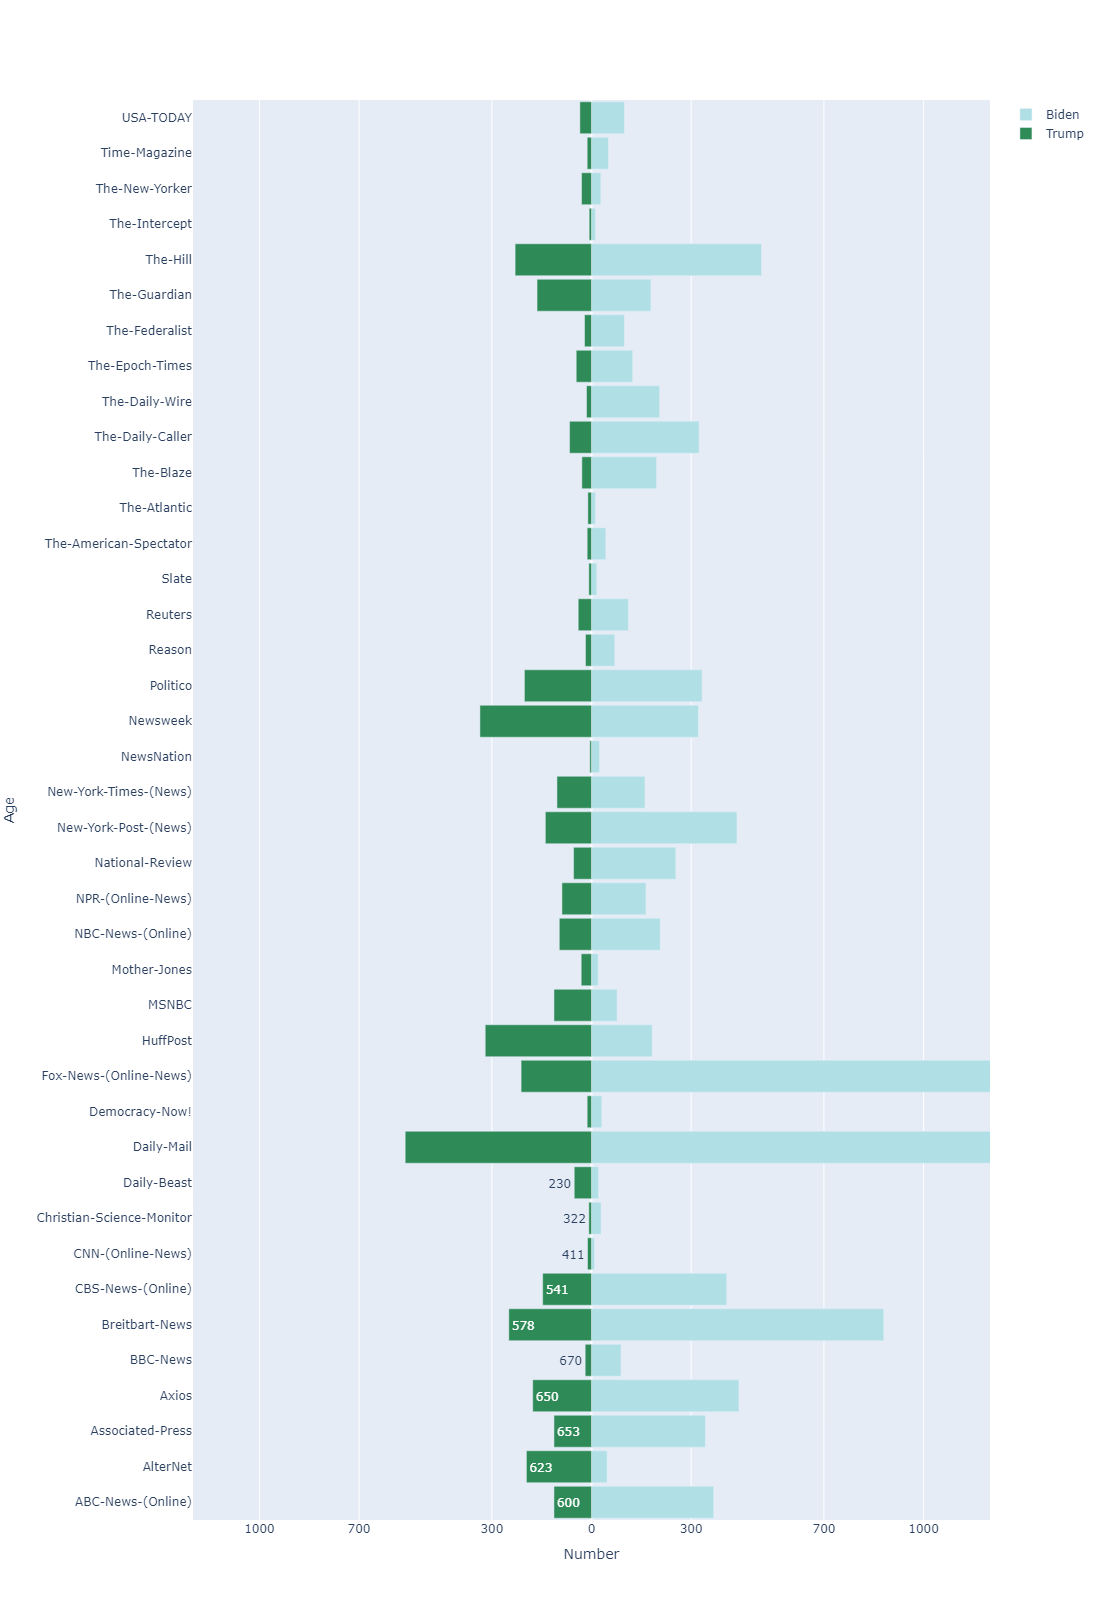

In [119]:
import plotly.express as py
import plotly.graph_objs as go

import numpy as np

layout = go.Layout(yaxis=go.layout.YAxis(title='Age'),
                   xaxis=go.layout.XAxis(
                       range=[-1200, 1200],
                       tickvals=[-1000, -700, -300, 0, 300, 700, 1000, 5000],
                       ticktext=[1000, 700, 300, 0, 300, 700, 1000, 5000],
                       title='Number'),
                   barmode='overlay',
                   bargap=0.1)

data = [go.Bar(y=counts.index,
               x=counts["Biden"],
               orientation='h',
               name='Biden',
               hoverinfo='x',
               marker=dict(color='powderblue')
               ),
        go.Bar(y=counts.index,
               x=[-x for x in counts["Trump"]],
               orientation='h',
               name='Trump',
               text=-1 * women_bins.astype('int'),
               hoverinfo='text',
               marker=dict(color='seagreen')
               )]

fig = go.Figure(data=data, layout=layout)
fig.update_layout( autosize=False, width=800, height=1600)
fig.show()

In [ ]:
df_front

In [8]:
# NER that occuuupy the largest area
df_frontpage['text_size'] = df_frontpage.apply(lambda row: (row['width'] * row['height']) / len(row['text']), axis=1)
df_frontpage

,x,y,height,width,tag,text,name,date,leaning,end,entity,index,score,start,word,neg,pos,word_2,text_size
0,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,5.0,B-PER,1.0,0.8995158,0.0,Biden,0.831232,0.168768,Biden,128.645833
1,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,20.0,B-PER,4.0,0.99745303,15.0,Putin,0.831232,0.168768,Putin,128.645833
2,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,48.0,B-LOC,8.0,0.99974483,41.0,Ukraine,0.831232,0.168768,Ukraine,128.645833
3,272,207,19,324,h2,Coaches made teen eat pizza despite religion: Suit,ABC-News-(Online),20220101000143,Lean Left,NaN,None,NaN,None,NaN,None,0.865781,0.134220,None,123.120000
4,272,247,19,297,h2,Suspect arrested in shooting of police officers,ABC-News-(Online),20220101000143,Lean Left,NaN,None,NaN,None,NaN,None,0.907020,0.092980,None,120.063830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982432,653,9594,47,285,h3,Iowa is the Front Line in a Battle Over Carbon Pipelines,Time-Magazine,20220301204820,Lean Left,56.0,B-MISC,8.0,0.9759724,28.0,Battle Over Carbon Pipelines,0.159295,0.840705,Battle Over Carbon Pipelines,239.196429
1982433,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,6.0,B-LOC,1.0,0.999783,0.0,Russia,0.369156,0.630844,Russia,348.879310
1982434,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,33.0,B-LOC,7.0,0.99859875,27.0,Europe,0.369156,0.630844,Europe,348.879310
1982435,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,58.0,B-MISC,10.0,0.9695156,39.0,Clean Energy Future,0.369156,0.630844,Clean Energy Future,348.879310


In [9]:
# stas for text_size
%matplotlib inline

# sns.histplot(data=df_frontpage, x="text_size", bins=10, kde=False) 
print(df_frontpage["text_size"].describe())

count    1.395461e+06
mean     3.054272e+02
std      5.785953e+02
min      3.000000e+01
25%      1.270116e+02
50%      1.876364e+02
75%      3.067826e+02
max      3.504384e+04
Name: text_size, dtype: float64


In [10]:
leanings = ['Left', 'Lean Left', 'Center', 'Lean Right', 'Right']
df_grouped = df_frontpage.groupby('leaning')

dfs_words_size = []
for x in leanings:
    # value counts of NER, weighted by 
    grouped = df_grouped.get_group(x).groupby('word_2')
    grouped_sum = grouped['text_size'].sum()
    most_salient_words = grouped_sum.nlargest(15)
    
    dfs_words_size.append(most_salient_words.to_frame())

(_deploy_ray_func pid=8688) SettingWithCopyWarning: 
(_deploy_ray_func pid=8688) A value is trying to be set on a copy of a slice from a DataFrame
(_deploy_ray_func pid=8688) 
(_deploy_ray_func pid=8688) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(_deploy_ray_func pid=8692) SettingWithCopyWarning:  [repeated 24x across cluster]
(_deploy_ray_func pid=8692) A value is trying to be set on a copy of a slice from a DataFrame [repeated 24x across cluster]
(_deploy_ray_func pid=8692)  [repeated 24x across cluster]
(_deploy_ray_func pid=8692) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [repeated 24x across cluster]


In [12]:
display_side_by_side(dfs_words_size, leanings) 

,text_size
word_2,
None,5776655.743559
Trump,665651.926532
Ukraine,556786.922840
Putin,323527.256591
Russia,319777.216569
Biden,274054.485838
Republican,273705.067172
U.S,225795.334567
AlterNet Media Inc,199231.250000


In [81]:
def print_row_highlight(x):
    original_string = x["text"]
    begin_i = int(x["index"])
    end_i = int(x["end"])
    
    new_string = original_string[:begin_i] + "\x1b[31m\"" + \
        original_string[begin_i : end_i] + "\"\x1b[0m" + original_string[end_i:]

    print(new_string)
    print(original_string[begin_i : end_i])
    print(x["word"])


print_row_highlight(df_frontpage.iloc[56])
# for x in df_frontpage[[x is not None and x.startswith("#") for x in df_frontpage["word"]]].iterrows():
    
#     break

B"iden" administration asks Supreme Court to hear 'Remain in Mexico' case
iden
Biden


In [58]:
df_sharp

,x,y,height,width,tag,text,name,date,leaning,end,entity,index,score,start,word,neg,pos
4922,1245,5881,30,357,div,"MATTHEW DICKS, BRANDON HERSEY, KATIE HOLBROOK,...",Slate,20220101064729,Left,22.0,B-PER,13.0,0.37550306,20.0,##ON,0.556501,0.443500
5037,328,3285,40,273,a,Journalist With Face Tattoo Makes History Anch...,The-Daily-Caller,20220101002140,Right,61.0,I-MISC,14.0,0.56289476,57.0,##time,0.222653,0.777347
5611,1279,1311,72,152,a,Why 2021 Was a Watershed Year for Press Freedoms,Time-Magazine,20220101001904,Lean Left,24.0,I-MISC,7.0,0.8533848,21.0,##hed,0.253124,0.746876
5659,481,5966,68,664,a,Biden Tries to Bring Comfort to Kentucky After...,Time-Magazine,20220101001904,Lean Left,28.0,B-PER,9.0,0.4375221,24.0,##fort,0.017861,0.982139
6521,387,515,60,196,div,A Healthy Homemade Soup to Jumpstart the New Year,The-Epoch-Times,20220101005134,Lean Right,18.0,I-MISC,5.0,0.61445713,14.0,##made,0.022127,0.977873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978794,942,4298,77,218,a,Why 2021 Was a Watershed Year for Press Freedoms,Time-Magazine,20220115105300,Lean Left,24.0,I-MISC,7.0,0.8533848,21.0,##hed,0.253124,0.746876
1978927,942,4418,77,218,a,Why 2021 Was a Watershed Year for Press Freedoms,Time-Magazine,20220120003304,Lean Left,24.0,I-MISC,7.0,0.8533848,21.0,##hed,0.253124,0.746876
1979064,942,4298,77,218,a,Why 2021 Was a Watershed Year for Press Freedoms,Time-Magazine,20220117205310,Lean Left,24.0,I-MISC,7.0,0.8533848,21.0,##hed,0.253124,0.746876
1979184,942,4190,77,218,a,Why 2021 Was a Watershed Year for Press Freedoms,Time-Magazine,20220122105315,Lean Left,24.0,I-MISC,7.0,0.8533848,21.0,##hed,0.253124,0.746876


In [43]:
# df_frontpage = pd.read_parquet('./processed_data/a1_data.parquet')
df_sharp = df_frontpage[[x is not None and x.startswith("#") for x in df_frontpage["word"]]]

In [52]:
m = max(df_sharp["score"])
df_sharp[df_sharp["score"] == m]["text"][0]

'U.S. joins U.K. and EU in sanctioning Putin, Lavrov'

In [ ]:
df_frontpage.to_parquet("./processed_data/a1_data.parquet")